In [147]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

from torchsummary import summary
import matplotlib.pyplot as plt

In [148]:
device = torch.device("cpu")

In [149]:
class NN(nn.Module):

    def __init__(self, input_size: int, num_classes: int):  # input size = 28x28 = 784 for mnist
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [150]:
NUM_PIXELS = 784 # 28x28
BATCH_SIZE = 32
NUM_CLASSES = 10 # 10 numbers: 0-9
EPOCHS = 5

In [151]:
transform = transforms.Compose([ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

100.0%
100.0%
100.0%
100.0%


In [152]:
# Hyperparameters
input_size = NUM_PIXELS # 28x28 pixels
learning_rate = 1e-3

# Initialize Network
model = NN(input_size=input_size, num_classes=NUM_CLASSES).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [153]:
# Train Network
for epoch in range(EPOCHS):  
# 1 epoch => Network has seen all the images in the dataset
    for batch_idx, (data, targets) in enumerate(train_loader):

        data = data.to(device=device)
        targets = targets.to(device=device)

        # print(data.shape)  # => [64 , 1, 28, 28] => 64 : num_images, 1 -> num_channels, (28,28): (height, width)
        data = data.reshape(data.shape[0], -1)  # Flatten
        if epoch == 0 and batch_idx == 0:
            print(data.shape)

        # forward
        scores = model(data)

        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()  # set all gradients to zero for each batch
        loss.backward()

        # gradient descent
        optimizer.step()

    print(f"Epoch: {epoch + 1}; Loss: {loss.item()}")

torch.Size([32, 784])
Epoch: 1; Loss: 0.21140389144420624
Epoch: 2; Loss: 0.23803463578224182
Epoch: 3; Loss: 0.042340878397226334
Epoch: 4; Loss: 0.16006658971309662
Epoch: 5; Loss: 0.07687302678823471


In [154]:
image, label = train_set[1]

image.shape

torch.Size([1, 28, 28])

In [155]:
nn_image = image.reshape(-1, NUM_PIXELS)
nn_image.shape

torch.Size([1, 784])

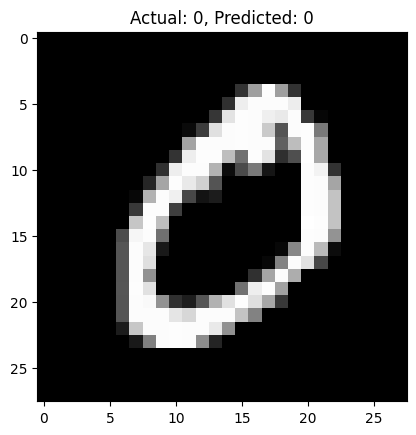

In [156]:
model.eval()
with torch.no_grad():  # dont compute gradients
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Actual: {label}, Predicted: {torch.argmax(model(nn_image)).item()}")
    plt.show()

In [157]:
summary(model=model, input_size=(NUM_PIXELS,), batch_size=BATCH_SIZE, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [32, 50]          39,250
            Linear-2                   [32, 10]             510
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.10
Forward/backward pass size (MB): 0.01
Params size (MB): 0.15
Estimated Total Size (MB): 0.26
----------------------------------------------------------------


## CNN - Convolutional Neural Network
Type of neural network specifically designed for processing data with grid-like topology.

### Basic Architecture
A CNN consists of several key layers that work together to process images:

- Convolutional Layers
    - Process small regions of the input image
    - Use filters (kernels) to detect features
    - Stack multiple layers to capture complex patterns
- Pooling Layers
    - Reduce spatial dimensions of feature maps
    - Help with feature extraction and computation efficiency
    - Common types: Max Pooling and Average Pooling
- Fully Connected Layers
    - Process flattened features for classification
    - Convert 2D/3D data into 1D for final predictions

![CNN](img/convolution.gif)

In [194]:
class CNN(nn.Module):
    def __init__(self, num_classes: int = 10):
        super(CNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1)
        
        # Average pooling layers
        self.max_pool = nn.AvgPool2d(kernel_size=(2, 2))
        
        # Fully connected layers
        self.fc1 = nn.Linear(64*3*3, 256)  # 64*3*3 features after flattening
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # First convolutional block
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)

        # Dropout
        # x = F.dropout(x, p=0.5, training=self.training)
        
        # Second convolutional block
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)

        # Third convolutional block
        x = F.relu(self.conv3(x))
        x = self.max_pool(x)
        
        # Flatten
        x = torch.flatten(x, 1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x)

# Initialize the model
model = CNN()

In [195]:
# Hyperparameters
learning_rate = 1e-3

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize Network
model = CNN(num_classes=NUM_CLASSES).to(device)

In [ ]:
# Train Network
for epoch in range(EPOCHS):  
# 1 epoch => Network has seen all the images in the dataset
    for batch_idx, (data, targets) in enumerate(train_loader):

        data = data.to(device=device)
        targets = targets.to(device=device)

        # print(data.shape)  # => [64 , 1, 28, 28] => 64 : num_images, 1 -> num_channels, (28,28): (height, width)
        if epoch == 0 and batch_idx == 0:
            print(data.shape)

        # forward
        scores = model(data)

        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()  # set all gradients to zero for each batch
        loss.backward()

        # gradient descent
        optimizer.step()

    print(f"Epoch: {epoch + 1}; Loss: {loss.item()}")

torch.Size([32, 1, 28, 28])


/tmp/ipykernel_403839/640432998.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch: 1; Loss: 2.3124947547912598
Epoch: 2; Loss: 2.3047547340393066


In [ ]:
cnn_image = image.unsqueeze(0)
cnn_image.shape

torch.Size([1, 1, 28, 28])

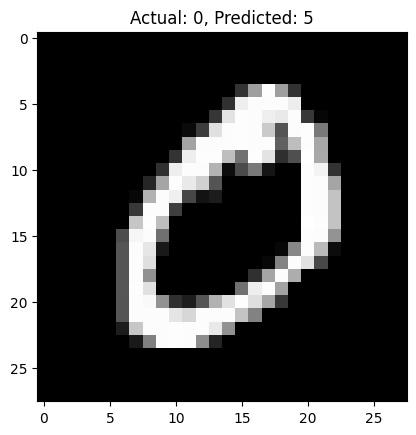

In [ ]:
model.eval()
with torch.no_grad():  # dont compute gradients
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Actual: {label}, Predicted: {torch.argmax(model(cnn_image), dim=1).item()}")
    plt.show()

In [ ]:
summary(model, input_size=(1, 28, 28), batch_size=BATCH_SIZE, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [32, 6, 28, 28]              60
         AvgPool2d-2            [32, 6, 14, 14]               0
            Conv2d-3           [32, 16, 14, 14]             880
         AvgPool2d-4             [32, 16, 7, 7]               0
            Linear-5                  [32, 120]          94,200
            Linear-6                   [32, 10]           1,210
Total params: 96,350
Trainable params: 96,350
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.10
Forward/backward pass size (MB): 2.42
Params size (MB): 0.37
Estimated Total Size (MB): 2.89
----------------------------------------------------------------
